In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch

from bo_functions import ExactGPModel
from bo_functions import create_y_data
from bo_functions import bo_iter
from bo_functions import test_train_split
from bo_functions import bo_iter_w_runs
from bo_functions import find_train_doc_path
from datetime import datetime

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = None ##For Testing

#Set Parameters
Theta_True = np.array([1,-1])
BO_iters = 3
train_iter = 300
noise_std = 0.1
runs = 2
explore_bias = torch.tensor([0.75])
explore_bias = torch.tensor([0])

sep_fact = 1
shuffle_seed = 9
set_lengthscale = None
t= 100
emulator = True
sparse_grid = True
verbose = True
save_fig = False

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/n=5.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
Yexp = exp_data[:,2]
n = len(Xexp)

#Define GP Testing space
p=20
Theta1 =  np.linspace(-2,2,p) #1x10
Theta2 =  np.linspace(-2,2,p) #1x10
theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays

Date and Time:  05-Aug-2022 (10:15:11)


Runs: 2
BO Iters: 3
----------------------------------------------------
Separation Factor Train/Test: 1
Lengthscale Set To: None
Initial Explore Bias: 0.0
Run Number:  1


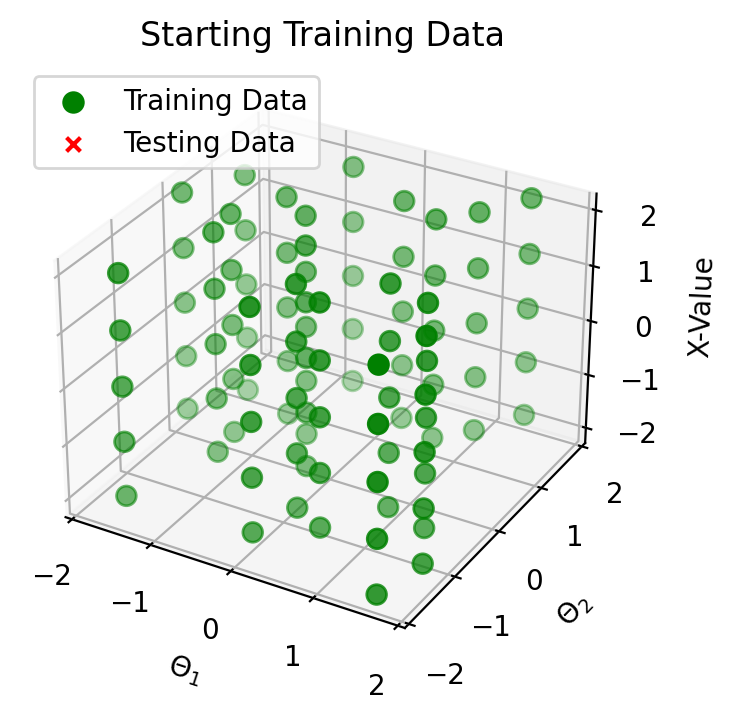

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution
/scratch365/mcarlozo/Toy_Problem/bo_functions.py:850: RuntimeWarning: invalid value encountered in sqrt
  SSE_stdev_GP[i,j] = np.sqrt(SSE_var_GP[i,j])


[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           1.70290766  -7.3701085  -10.64420031   2.92538594
    1.02882505   0.           0.           0.           3.35244876]
 [  0.      

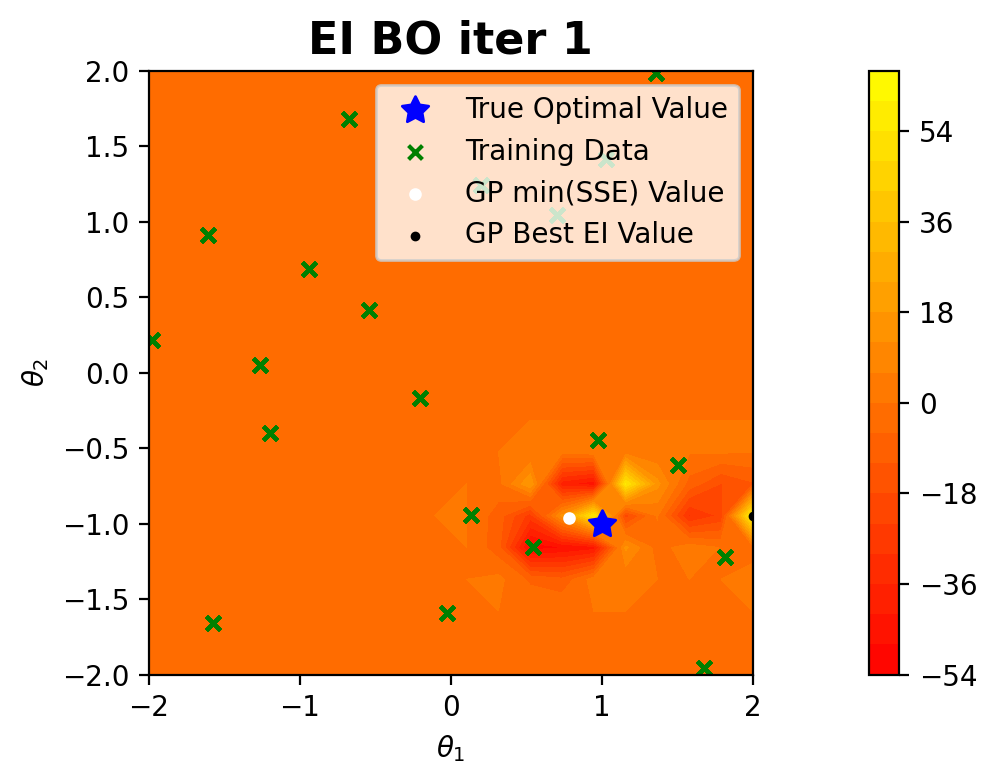

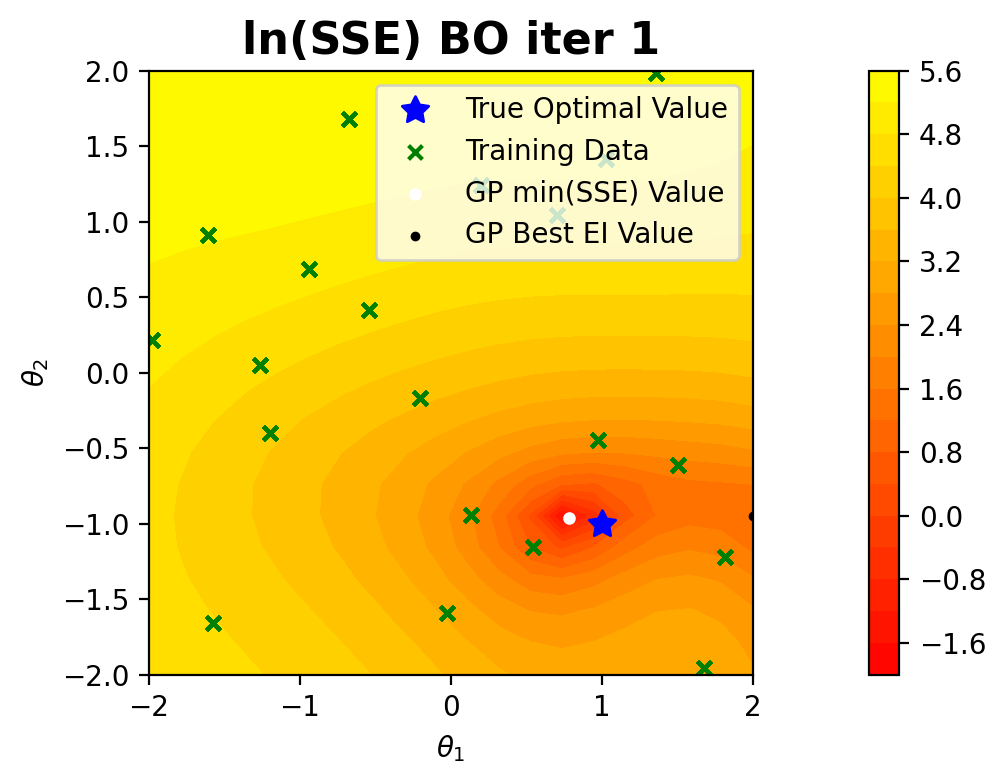

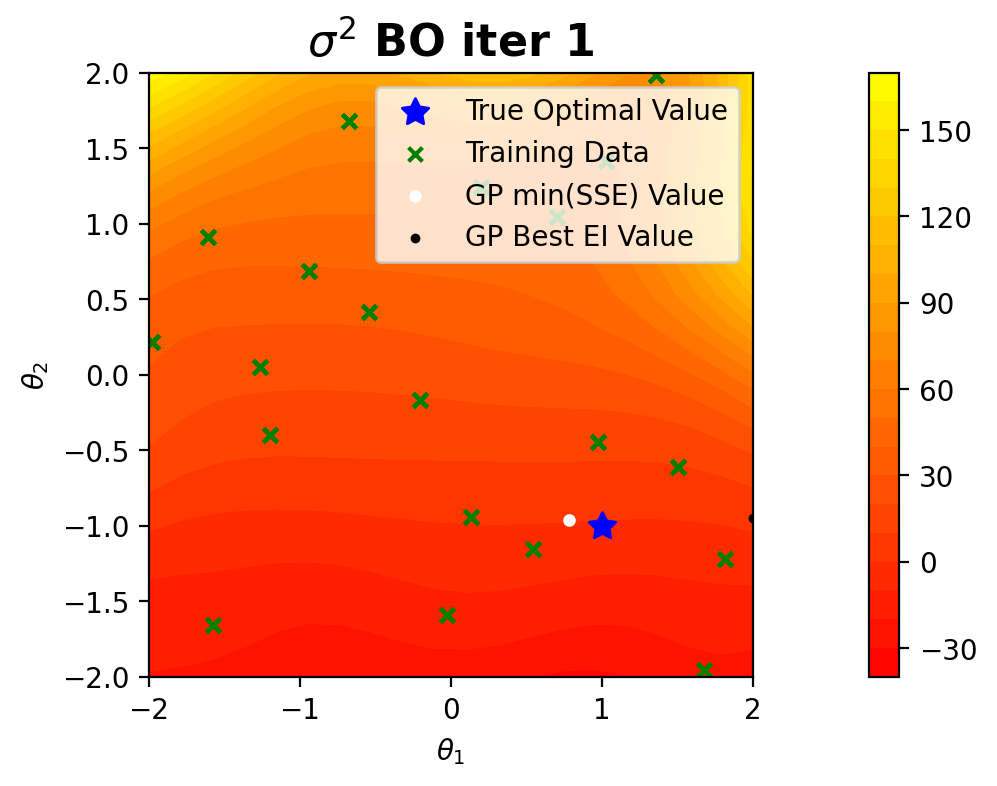

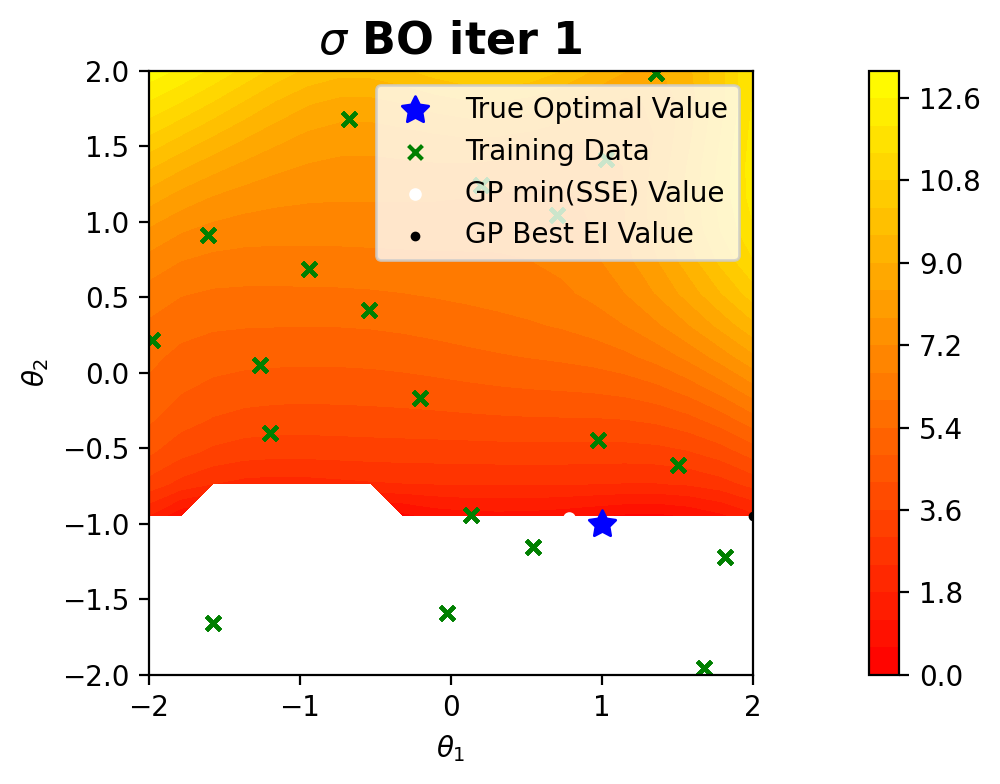

Best Error is: 2.8225
Magnitude of ln(SSE) given Theta_Opt =  [ 0.78260045 -0.96536033] is -7.0104e-01
[[  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.        ]
 [  0.           0.           0.           0.           0.
    0.           0.           0.           0.           0.
    0.           0.           0.           1

In [ ]:
%%time
obj = "obj"

all_data_doc = find_train_doc_path(emulator, obj, t)
all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=",")) 

print("Runs:", runs)
print("BO Iters:", BO_iters)
print("----------------------------------------------------")
print("Separation Factor Train/Test:", str(np.round(sep_fact,3)))
print("Lengthscale Set To:", set_lengthscale)
print("Initial Explore Bias:", str(np.round(float(explore_bias[0]),3)))
results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,Theta_True,train_iter,explore_bias[0], Xexp, Yexp,
                             noise_std, obj, runs, sparse_grid, emulator, set_lengthscale, verbose, 
                             save_fig, shuffle_seed, DateTime, sep_fact = sep_fact)
print("The GP predicts the lowest SSE of", "{:.3e}".format(np.exp(results[3])), "occurs at \u03B8 =", results[2][0], 
          "during run", results[1], "at BO iteration", results[0])
print("At this point, the highest EI occurs at \u03B8 =", results[4][0])
print("\n")